---
title: Working with pyCATHY and DA
subtitle: PART1 - DA and ERT assimilation
license: CC-BY-4.0
github: https://github.com/BenjMy/ETH_pyCATHY/
subject: Tutorial
authors:
  - name: Benjamin Mary
    email: benjamin.mary@ica.csic.es
    corresponding: true
    orcid: 0000-0001-7199-2885
    affiliations:
      - ICA-CSIC
date: 2024/04/12
---

```{toc} Table of Contents
:depth: 3
```

In [1]:
import pyCATHY
from pyCATHY import cathy_tools
from pyCATHY.ERT import petro_Archie as Archie
from pyCATHY.importers import cathy_inputs as in_CT
import pyCATHY.meshtools as cathy_meshtools

import utils

In [2]:
import pygimli as pg
from pygimli.physics import ert
import pygimli.meshtools as mt

In [3]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib as mpl
# set some default plotting parameters for nicer looking plots
mpl.rcParams.update({"axes.grid":True, 
                     "grid.color":"gray", 
                     "grid.linestyle":'--',
                     'figure.figsize':(10,10)}
                   )
import pandas as pd

## Create a pyCATHY object

In [4]:
# Create a CATHY project
# -----------------------
simu_solution = cathy_tools.CATHY(
                                    dirName='./solution_ERT',
                                    prj_name= 'weill_dataset',
                                    notebook=True,
                                  )

simu_solution.create_mesh_vtk()

🏁 Initiate CATHY object

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🔄 Update hap.in file

🔄 update dem_parameters file 

🔄 update dem_parameters file 

🛠  Recompile src files [3s]

🍳 gfortran compilation [7s]

b''

👟 Run processor

## Check the mesh

In [5]:
meshpath = os.path.join(simu_solution.workdir,
                        simu_solution.project_name,
                        'vtk',
                        simu_solution.project_name + '.vtk'
                       )
meshCATHY = pv.read(meshpath)

## Change atmospheric boundary conditions and run simulation

In [17]:
netValue = -1e-7
rain = 4e-7
tatmbc = list(np.linspace(0,86400,10))

netValue_list = [netValue]*len(tatmbc)
netValue_list[0] = netValue + rain
netValue_list[1] = netValue + rain

simu_solution.update_atmbc(
                            HSPATM=1,
                            IETO=0,
                            time=tatmbc,
                            # VALUE=[None, None],
                            netValue=netValue_list,
                    )

simu_solution.update_ic(INDP=0,IPOND=0,
                        pressure_head_ini=-1,
                        )


simu_solution.update_parm(TIMPRTi=tatmbc)
simu_solution.update_soil(PMIN=-1e25)


# In[21]:
# ss

simu_solution.run_preprocessor()
simu_solution.run_processor(IPRT1=3)
simu_solution.run_processor(IPRT1=2,
                             TRAFLAG=0,
                             VTKF=2,
                             )


🔄 Update atmbc

🔄 update parm file 

🔄 Update ic

Single value detected for ic ==> assumming it homogeneous

🔄 update parm file 

─────────────────────────────────────────── ⚠ warning messages above ⚠ ────────────────────────────────────────────

['Adjusting NPRT with respect to time of interests requested\n']

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🔄 Update soil

homogeneous soil

🍳 gfortran compilation

👟 Run preprocessor

🔄 update parm file 

🛠  Recompile src files [515s]

🍳 gfortran compilation [518s]

b''

👟 Run processor

🔄 update parm file 

🛠  Recompile src files [518s]

🍳 gfortran compilation [521s]

b''

👟 Run processor

## Create 2D pygimli mesh (on top of CATHY mesh)

In [7]:
dem_mat, str_hd_dem = in_CT.read_dem(
                                    os.path.join(simu_solution.workdir, 
                                                 simu_solution.project_name, 
                                                 "prepro/dem"),
                                    os.path.join(simu_solution.workdir, 
                                                 simu_solution.project_name, 
                                                 "prepro/dtm_13.val"),
                                    )


idC = 8
idL = 8

minmax_dem_mat_Ci = [min(dem_mat[:,idC]), max(dem_mat[:,idC])]
minmax_dem_mat_Li = [min(dem_mat[idL,:]), max(dem_mat[idL,:])]

geomCi = mt.createPolygon([[0.0, -1], [0, minmax_dem_mat_Ci[0]], [10, minmax_dem_mat_Ci[1]], [10, -1]],
                          isClosed=True, marker=1, area=1e-2)
meshCi = mt.createMesh(geomCi, quality=34.3, area=3, smooth=[1, 10])

geomLi = mt.createPolygon([[0.0, -1], [0, minmax_dem_mat_Li[1]], [10, minmax_dem_mat_Li[0]], [10, -1]],
                          isClosed=True, marker=1, area=1e-2)
meshLi = mt.createMesh(geomLi, quality=34.3, area=3, smooth=[1, 10])


(<Axes: >, None)

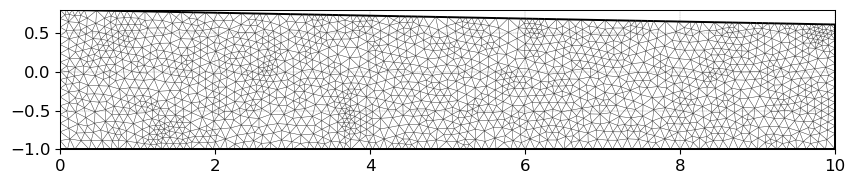

In [8]:
pg.show(meshLi)

### Export and read with pyvista

In [9]:

meshCi.exportVTK('meshCi.vtk')
meshCiPG_PGref = pv.read('meshCi.vtk')

meshLi.exportVTK('meshLi.vtk')
meshLiPG_PGref = pv.read('meshLi.vtk')


(meshCiPG, meshLiPG) = utils.define_mesh_transformations(meshCiPG_PGref,
                                                      meshLiPG_PGref,
                                                      idC=10, 
                                                      idL=10,
                                                    )
meshCiPG

UnstructuredGrid (0x7f99d7b32200)
  N Cells:    3270
  N Points:   1733
  X Bounds:   5.000e+00, 5.000e+00
  Y Bounds:   0.000e+00, 1.000e+01
  Z Bounds:   -1.000e+00, 9.200e-01
  N Arrays:   1

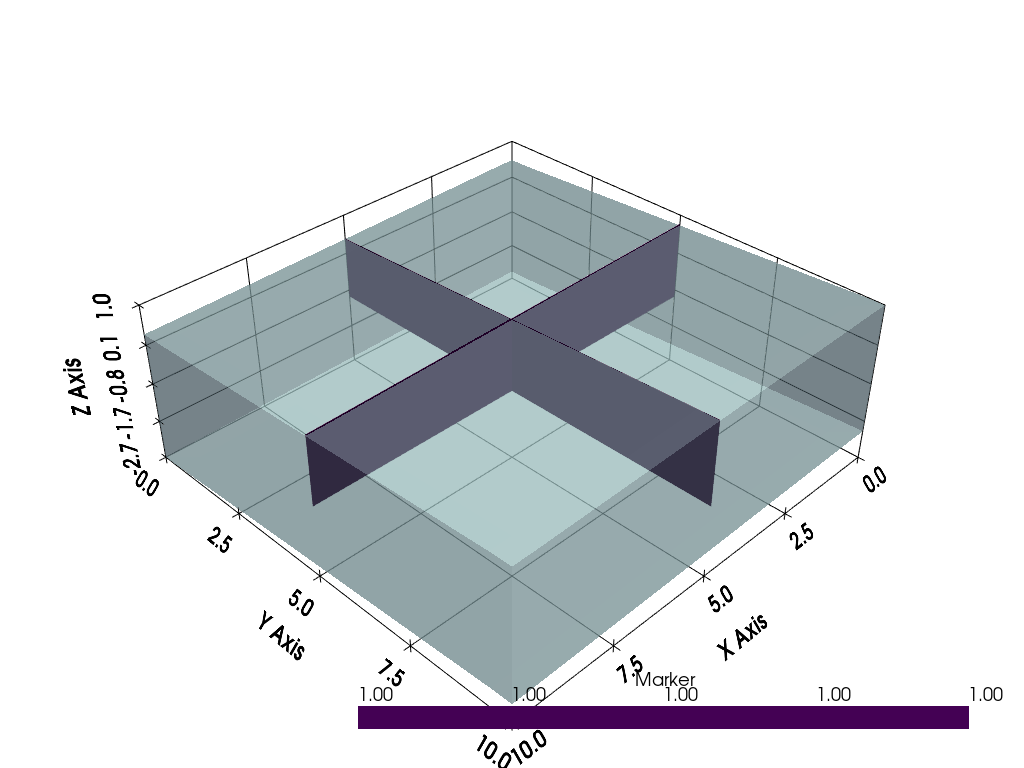

In [10]:
pl = pv.Plotter()
pl.add_mesh(meshCiPG)
pl.add_mesh(meshLiPG)
pl.add_mesh(meshCATHY,opacity=0.5)
pl.show_grid()
pl.show()

## Interpolate CATHY mesh on PG mesh

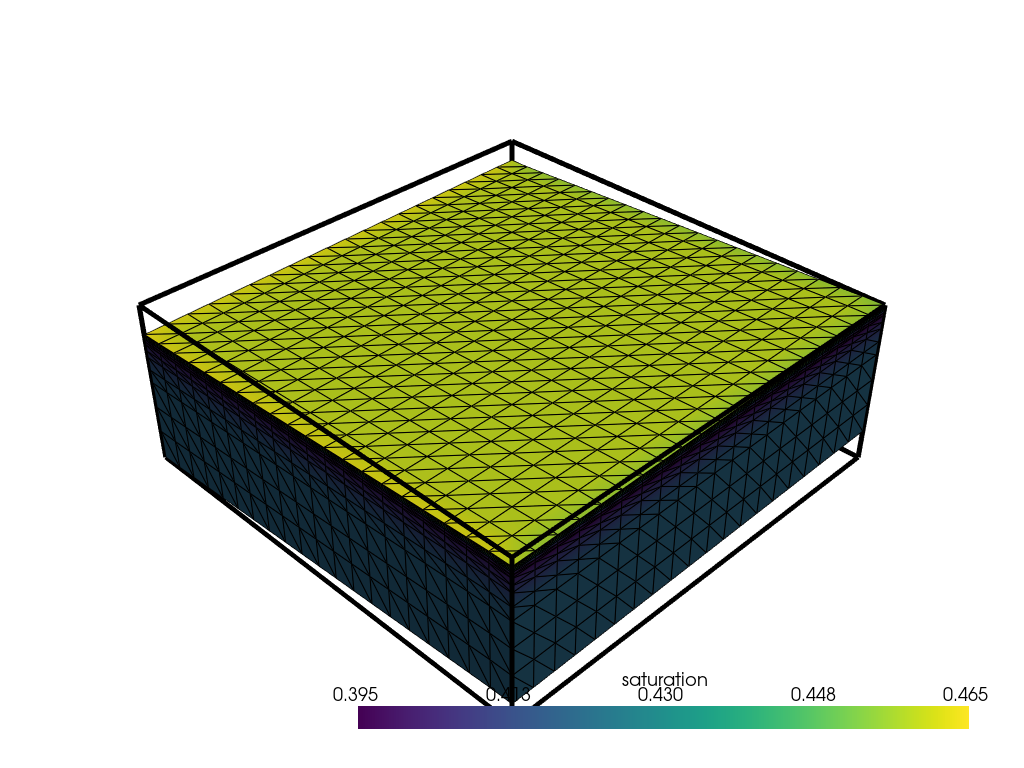

min 0.40900394320487976, max 0.40900394320487976, median 0.41980549693107605 
add new attribute to pg mesh
end of CATHY_2_pg


In [11]:
ERT_meta_dict_meshLi={
                'forward_mesh_vtk_file': 'meshLi.vtk',
                'mesh_nodes_modif': meshLiPG.points
}

meshpath = os.path.join(simu_solution.workdir,
                        simu_solution.project_name,
                        'vtk',
                        '110.vtk'
                       )
meshCATHY = pv.read(meshpath)

p = pv.Plotter(notebook=True)
p.add_mesh(meshCATHY, scalars='saturation',show_edges=True)
_ = p.add_bounding_box(line_width=5, color="black")
cpos = p.show()

        
meshLi_PG_withSaturation, scalar_new = cathy_meshtools.CATHY_2_pg(meshCATHY,
                                                       ERT_meta_dict_meshLi,
                                                        # show=True,
                                                      )

## Forward modelling of ER apparent datasets

### Create ERT scheme

In [12]:
scheme = ert.createData(elecs=np.linspace(start=0, 
                                          stop=10, 
                                          num=21),
                           schemeName='dd')

### Define Archie Parameters

In [13]:
sc = {}
rFluid_Archie = 1/(588*(1e-6/1e-2))
sc = {
    "POROS": [simu_solution.soil_SPP['SPP_map']['POROS'].mean()],
    "rFluid_Archie": [rFluid_Archie],
    "a_Archie": [0.3],
    "m_Archie": [1.7],
    "n_Archie": [1.7],
    "pert_sigma_Archie": [0],
}

### ERT simulate

In [16]:
for i in range(len(tatmbc)):

    # read in CATHY mesh data
    # ------------------------------------------------------------------------
    path_CATHY = os.path.join(simu_solution.workdir, 
                              simu_solution.project_name , 
                              'vtk/'
                              )
    if i<10:    
        filename = "10" + str(i) + ".vtk"
    elif i<100:
        filename = "1" + str(i) + ".vtk"
    
    meshCATHY = pv.read(path_CATHY+filename)
            
    meshLi_PG_withSaturation, scalar_new = cathy_meshtools.CATHY_2_pg(meshCATHY,
                                                                      ERT_meta_dict_meshLi,
                                                                      # show=True,
                                                                      )
    saturation = np.array(meshLi_PG_withSaturation[scalar_new])
    ER_converted_ti_noNoise = Archie.Archie_rho_DA(
                                                   sat = [saturation],
                                                   rFluid_Archie=sc['rFluid_Archie'], 
                                                   porosity=sc['POROS'], 
                                                   a_Archie=sc['a_Archie'], 
                                                   m_Archie=sc['m_Archie'], 
                                                   n_Archie=sc['n_Archie'],
                                                   pert_sigma_Archie=[0]
                                                   )
    rhomap = np.array(ER_converted_ti_noNoise)
    data = ert.simulate(meshLi, 
                        scheme=scheme, 
                        res=rhomap, 
                        noiseLevel=1,
                        noiseAbs=1e-6, 
                        seed=1337
                        )
    
    data.save('ERTsolution/ERT_Li_' + str(i) + '.data')

min 0.42011550068855286, max 0.42011550068855286, median 0.42011550068855286 
add new attribute to pg mesh
end of CATHY_2_pg


See eq. 4.4 thesis Isabelle p.95

max res after Archie

61.57445

29/04/24 - 18:07:10 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000315327379185 : 0.014505037604831583


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0108766 s
FOP updating mesh dependencies ... 1.184e-06 s
Calculating response for model: min = 61.5745 max = 61.5745
Allocating memory for primary potential...... 0.000973021

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found 

See eq. 4.4 thesis Isabelle p.95

max res after Archie

61.57445

29/04/24 - 18:07:10 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000315327399083 : 0.01450503861555551


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0071434 s
FOP updating mesh dependencies ... 1.163e-06 s
Calculating response for model: min = 61.5744 max = 61.5745
Allocating memory for primary potential...... 0.000248769

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found 

See eq. 4.4 thesis Isabelle p.95

max res after Archie

61.57445

29/04/24 - 18:07:11 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000322534100704 : 0.014724054471440344


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00686499 s
FOP updating mesh dependencies ... 2.862e-06 s
Calculating response for model: min = 46.5426 max = 61.5745
Allocating memory for primary potential...... 0.000235189

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found

See eq. 4.4 thesis Isabelle p.95

max res after Archie

61.620255

29/04/24 - 18:07:12 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000323098958116 : 0.01473148086933776


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0071745 s
FOP updating mesh dependencies ... 1.109e-06 s
Calculating response for model: min = 46.9318 max = 61.6203
Allocating memory for primary potential...... 0.000239208

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found 

See eq. 4.4 thesis Isabelle p.95

max res after Archie

61.98547

relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100

29/04/24 - 18:07:13 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000320964797757 : 0.01468705875445498


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false

Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00853965 s
FOP updating mesh dependencies ... 1.024e-06 s
Calculating response for model: min = 49.0413 max = 61.9855
Allocating memory for primary potential...... 0.00026229

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00805264 s
FOP updating mesh dependencies ... 1.191e-06 s
Forward: time: 0.5148

See eq. 4.4 thesis Isabelle p.95

max res after Archie

62.351254

29/04/24 - 18:07:14 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000319071807777 : 0.014653256506142517


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00798274 s
FOP updating mesh dependencies ... 1.141e-06 s
Calculating response for model: min = 50.5304 max = 62.3513
Allocating memory for primary potential...... 0.000239112

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found

See eq. 4.4 thesis Isabelle p.95

max res after Archie

62.736977

ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


29/04/24 - 18:07:14 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000317243866148 : 0.014622741424026635


Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00726826 s
FOP updating mesh dependencies ... 1.162e-06 s
Calculating response for model: min = 51.7557 max = 62.737
Allocating memory for primary potential...... 0.000238389

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.0064903 s
FOP updating mesh dependencies ... 1.081e-06 s
Forward: time: 0.501721s
Interpolating to secondary mesh

315 	/ 315
Forward: time: 0.703084s
Response: min = 2.3

See eq. 4.4 thesis Isabelle p.95

max res after Archie

63.151543

ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100

29/04/24 - 18:07:15 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000315448144384 : 0.014593976393825387



Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00708765 s
FOP updating mesh dependencies ... 1.134e-06 s
Calculating response for model: min = 52.8622 max = 63.1515
Allocating memory for primary potential...... 0.000251803

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00654602 s
FOP updating mesh dependencies ... 1.461e-06 s
Forward: time: 0.497011s
Interpolating to secondary mesh

315 	/ 315
Forward: time: 0.699297s
Response: min = 2.32927 max = 54.432 mean = 32.422
Reciprocity rm

See eq. 4.4 thesis Isabelle p.95

max res after Archie

63.574947

29/04/24 - 18:07:16 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000313673492522 : 0.014566368749887627


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00708047 s
FOP updating mesh dependencies ... 1.028e-06 s
Calculating response for model: min = 53.9225 max = 63.5749
Allocating memory for primary potential...... 0.000288413

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found

See eq. 4.4 thesis Isabelle p.95

max res after Archie

64.00641

29/04/24 - 18:07:17 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000311914451514 : 0.014539610218211783


ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00908692 s
FOP updating mesh dependencies ... 1.124e-06 s
Calculating response for model: min = 54.957 max = 64.0064
Allocating memory for primary potential...... 0.000239707

No primary potential for secondary field calculation with topography.
Creating P2-Primmesh:		Nodes: 7132	Cells: 3459	Boundaries: 5295
ModellingBase::setMesh() copying new mesh ... Found Neumann domain. Setting topography=1.
Found Neumann domain. but 2.5D -> neumann: false
Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.25, rMax = 20
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00656782 s
FOP updating mesh dependencies ... 1.034e-06 s
Forward: time: 0.50047